# AA


## 1. Importación de datos

In [132]:
import pandas as pd
import numpy as np

df = pd.io.parsers.read_csv(
    '/home/alexfrancow/AAA/ransomware2s.csv',
     header=None
    )


pcapData = pd.read_csv('/home/alexfrancow/AAA/ransomware2s.csv')
pcapData.columns = ['no', 'time', 'X', 'A', 'ipsrc', 'ipdst', 'proto', 'len']
pcapData['info'] = "null"
pcapData.parse_dates=["time"]

pcapData['num'] = 1
df = pcapData
df.head(3)



,no,time,X,A,ipsrc,ipdst,proto,len,info,num
0,1,2017-03-20 17:08:53,0s,49369 > 80 [SYN] Seq=0 Win=8192 Len=0 MSS=14...,10.3.20.102,37.202.7.169,TCP,66,null,1
1,2,2017-03-20 17:08:54,0s,"80 > 49369 [SYN, ACK] Seq=0 Ack=1 Win=64240 ...",37.202.7.169,10.3.20.102,TCP,60,null,1
2,3,2017-03-20 17:08:54,0s,49369 > 80 [ACK] Seq=1 Ack=1 Win=64240 Len=0,10.3.20.102,37.202.7.169,TCP,60,null,1


## 2. Agrupación de datos

In [146]:
df['time'] = pd.to_datetime(df['time'])
df.index = df['time']
data = df.copy()


dataGroup = pd.DataFrame({'count': data.groupby(['ipdst', 'proto', data.index]).size()}).reset_index()
pd.options.display.float_format = '{:,.0f}'.format
dataGroup.index = dataGroup['time']

%time dataGroup2 = dataGroup.groupby(['ipdst','proto']).resample('5S', on='time').sum().reset_index().dropna()
dataGroup2 = dataGroup2.head(5)
dataGroup2


CPU times: user 3.2 s, sys: 0 ns, total: 3.2 s
Wall time: 3.27 s


,ipdst,proto,time,count
0,10.3.20.102,HTTP,2017-03-20 17:08:55,3
7,10.3.20.102,HTTP,2017-03-20 17:09:30,1
8,10.3.20.102,TCP,2017-03-20 17:08:50,3
9,10.3.20.102,TCP,2017-03-20 17:08:55,104
10,10.3.20.102,TCP,2017-03-20 17:09:00,204


## 3. Normalización de datos
http://sebastianraschka.com/Articles/2014_about_feature_scaling.html#about-min-max-scaling 

In [147]:
dataNorm = dataGroup2.copy()
dataNorm['count_n'] = (dataGroup2['count'] - dataGroup2['count'].min()) / (dataGroup2['count'].max() - dataGroup2['count'].min())
dataNorm = data_normalized1.head(5)
dataNorm

,count,count_n
0,3,0
7,1,0
8,3,0
9,104,1
10,204,1


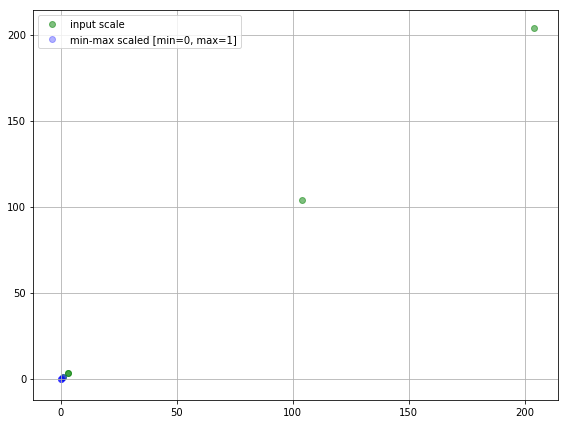

In [124]:
%matplotlib inline

from matplotlib import pyplot as plt

def plot():
    plt.figure(figsize=(8,6))

    plt.scatter(dataGroup2['count'], dataGroup2['count'],
            color='green', label='input scale', alpha=0.5)
        
    plt.scatter(dataNorm['count_n'], dataNorm['count_n'],
            color='blue', label='min-max scaled [min=0, max=1]', alpha=0.3)
    
    plt.legend(loc='upper left')
    plt.grid()

    plt.tight_layout()

plot()
plt.show()


### 3.1 Vanilla Python

In [125]:
# Standardization

x = dataGroup2['count']
mean = sum(x)/len(x)
std_dev = (1/len(x) * sum([ (x_i - mean)**2 for x_i in x]))**0.5

z_scores = [(x_i - mean)/std_dev for x_i in x]
print(z_scores)
# Min-Max scaling

minmax = [(x_i - min(x)) / (max(x) - min(x)) for x_i in x]
print(minmax)

[-0.74299773604806973, -0.76776432724967203, -0.74299773604806973, 0.50771511963284766, 1.7460446797129638]
[0.009852216748768473, 0.0, 0.009852216748768473, 0.5073891625615764, 1.0]


### 3.2 NumPy

In [126]:
import numpy as np

# Standardization

x_np = np.asarray(x)
z_scores_np = (x_np - x_np.mean()) / x_np.std()
print(z_scores_np)

# Min-Max scaling

np_minmax = (x_np - x_np.min()) / (x_np.max() - x_np.min())
print(np_minmax)

[-0.74299774 -0.76776433 -0.74299774  0.50771512  1.74604468]
[ 0.00985222  0.          0.00985222  0.50738916  1.        ]


### 3.3 Visualization

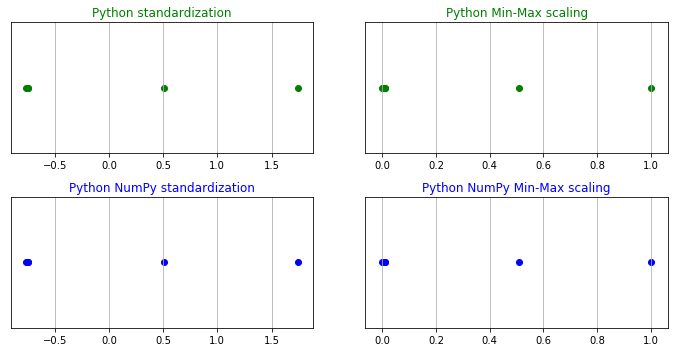

In [127]:
from matplotlib import pyplot as plt

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(10,5))

y_pos = [0 for i in range(len(x))]

ax1.scatter(z_scores, y_pos, color='g')
ax1.set_title('Python standardization', color='g')

ax2.scatter(minmax, y_pos, color='g')
ax2.set_title('Python Min-Max scaling', color='g')

ax3.scatter(z_scores_np, y_pos, color='b')
ax3.set_title('Python NumPy standardization', color='b')

ax4.scatter(np_minmax, y_pos, color='b')
ax4.set_title('Python NumPy Min-Max scaling', color='b')

plt.tight_layout()

for ax in (ax1, ax2, ax3, ax4):
    ax.get_yaxis().set_visible(False)
    ax.grid()

plt.show()


## 4. Isolation Forest

In [148]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import IsolationForest

dataNorm = dataNorm[['count','count_n']]
datatrain = dataNorm.iloc[0:5]

iforest = IsolationForest(n_estimators=100, contamination=0.00001, max_samples=5)
iforest.fit(datatrain)
clf = iforest.fit(datatrain)
prediction = iforest.predict(data_normalized1)

dataGroup2['prediction'] = prediction
dataGroup2

,ipdst,proto,time,count,prediction
0,10.3.20.102,HTTP,2017-03-20 17:08:55,3,1
7,10.3.20.102,HTTP,2017-03-20 17:09:30,1,1
8,10.3.20.102,TCP,2017-03-20 17:08:50,3,1
9,10.3.20.102,TCP,2017-03-20 17:08:55,104,1
10,10.3.20.102,TCP,2017-03-20 17:09:00,204,-1


## Plot Isolation Forest

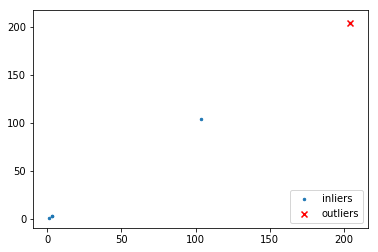

In [129]:
x = dataGroup2[(dataGroup2['prediction'] == -1)]['count'].values

fig, ax = plt.subplots()
ax.scatter(dataGroup2['count'], dataGroup2['count'], s=6, label="inliers")
ax.scatter(x, x, marker="x", color="r", label="outliers")
ax.legend(loc="lower right")